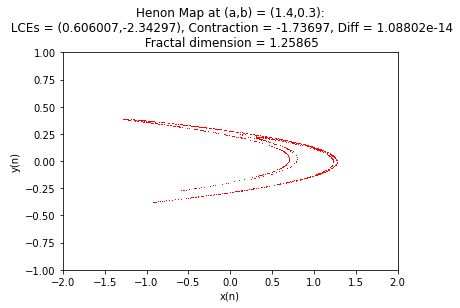

In [2]:
# HenonMap.py:
#   Estimate the Henon map's Lyapunov Characteristic Exponent,
#       using the pull-back method.
#       This should be compared to directly using Jacobian eigenvalues.
#   Also, estimate the area contraction rate and the fractal dimension,
#       using the Kaplan-Yorke formula.
#   Plot out iterates of Henon's 2D map, listing the LCE estimate.
#
# The Henon Map is given by
#     x_n+1 = f( x_n , y_n )
#     y_n+1 = g( x_n , y_n )
# with
#     f(x,y) = y + 1 - a x^2
#     g(x,y) = b x
#
# The state space is R^2
# and the control parameters range in
#       a in [0,2]
#       b in [0,1]
# Henon's original parameters for a chaotic attractor:
#       (a,b) = (1.4,0.3)
#
# It has a tangent map (d = partial derivative)
#     df/dx (x,y) = - 2 a x
#     df/dy (x,y) = 1
#     dg/dx (x,y) = b
#     dg/dy (x,y) = 0
# and area contraction given by
#     Determinant(Jacobian(x,y)) = -b
# As a check, we must have total contraction = Sum of LCEs
#     log(abs(D)) = maxLCE + minLCE
# Numerical check: at (a,b) = (1.4,0.3)
#     maxLCE ~  0.61
#     minLCE ~ -2.34
#     log(D) ~ -1.73
# These use base-2 logs
# 
# Note: Return is a list: the next (x,y)
def HenonMap(a,b,x,y):
    return y + 1.0 - a *x*x, b * x

# Return is a list: the next tangent vector
def HenonMapTangent(a,b,x,y,dx,dy):
    return dy - 2.0 * a * x * dx, b * dx

# The area contraction rate
def HenonMapDetJac(a,b,x,y):
    return -b

# The fractal dimension from the LCEs (Kaplan-Yorke conjecture)
def FractalDimension(maxLCE,minLCE):
    if maxLCE < 0.0:
        return 0.0
    else:
        return 1.0 + maxLCE / abs(minLCE)

# Import plotting routines
from pylab import *

# Simulation parameters
#
# Control parameters:
a = 1.4
b = 0.3
# The number of iterations to throw away
nTransients = 100
# The number of iterations to generate
nIterates = 1000

# Initial condition for iterates to plot
xtemp = 0.1
ytemp = 0.3
# Let's through away some number of transients, so that we're on an attractor
for n in range(0,nTransients):
    xtemp, ytemp = HenonMap(a,b,xtemp,ytemp)
# Set up arrays of iterates (x_n,y_n) and set the initial condition
x = [xtemp]
y = [ytemp]
# The main loop that generates iterates and stores them for plotting
for n in range(0,nIterates):
    # at each iteration calculate (x_n+1,y_n+1)
    xtemp, ytemp = HenonMap(a,b,x[n],y[n])
    # and append to lists x and y
    x.append( xtemp )
    y.append( ytemp )

# Estimate the LCEs
# The number of iterations to throw away
nTransients = 200
# The number of iterations to over which to estimate
nIterates = 10000
# Initial condition
xState = 0.0
yState = 0.0
# Initial tangent vectors
e1x = 1.0
e1y = 0.0
e2x = 0.0
e2y = 1.0
# Iterate away transients and let the tangent vectors align
#    with the global stable and unstable manifolds
for n in range(0,nTransients):
    xState, yState = HenonMap(a,b,xState,yState)
  # Evolve tangent vector for maxLCE
    e1x, e1y = HenonMapTangent(a,b,xState,yState,e1x,e1y)
  # Normalize the tangent vector's length
    d = sqrt(e1x*e1x + e1y*e1y)
    e1x = e1x / d
    e1y = e1y / d
  # Evolve tangent vector for minLCE
    e2x, e2y = HenonMapTangent(a,b,xState,yState,e2x,e2y)
  # Pull-back: Remove any e1 component from e2
    dote1e2 = e1x * e2x + e1y * e2y
    e2x = e2x - dote1e2 * e1x
    e2y = e2y - dote1e2 * e1y
  # Normalize second tangent vector
    d = sqrt(e2x*e2x + e2y*e2y)
    e2x = e2x / d
    e2y = e2y / d
# Okay, now we're ready to begin the estimation
# This is essentially the same as above, except we accumulate estimates
# We have to set the min,max LCE estimates to zero, since they are sums
maxLCE = 0.0
minLCE = 0.0
for n in range(0,nIterates):
  # Get next state
    xState, yState = HenonMap(a,b,xState,yState)
  # Evolve tangent vector for maxLCE
    e1x, e1y = HenonMapTangent(a,b,xState,yState,e1x,e1y)
  # Normalize the tangent vector's length
    d = sqrt(e1x*e1x + e1y*e1y)
    e1x = e1x / d
    e1y = e1y / d
  # Accumulate the stretching factor (tangent vector's length)
    maxLCE = maxLCE + log(d)
  # Evolve tangent vector for minLCE
    e2x, e2y = HenonMapTangent(a,b,xState,yState,e2x,e2y)
  # Pull-back: Remove any e1 component from e2
    dote1e2 = e1x * e2x + e1y * e2y
    e2x = e2x - dote1e2 * e1x
    e2y = e2y - dote1e2 * e1y
  # Normalize second tangent vector
    d = sqrt(e2x*e2x + e2y*e2y)
    e2x = e2x / d
    e2y = e2y / d
  # Accumulate the shrinking factor (tangent vector's length)
    minLCE = minLCE + log(d)

# Convert to per-iterate LCEs and to base-2 logs
maxLCE = maxLCE / float(nIterates) / log(2.)
minLCE = minLCE / float(nIterates) / log(2.)
# Calculate contraction factor, for comparison
#    We know this is independent of (x,y).
#    Otherwise, we'd have to estimate it along the trajectory, too.
Contraction = log(abs(HenonMapDetJac(a,b,0.0,0.0))) / log(2.)
# Setup the plot
xlabel('x(n)') # set x-axis label
ylabel('y(n)') # set y-axis label
# Set plot title
LCEString = '(%g,%g)' % (maxLCE,minLCE)
PString   = '(%g,%g)' % (a,b)
CString   = 'Contraction = %g, Diff = %g' % (Contraction,abs(maxLCE+minLCE-Contraction))
FString   = 'Fractal dimension = %g' % FractalDimension(maxLCE,minLCE)
title('Henon Map at (a,b) = ' + PString + ':\n LCEs = ' + LCEString + ', ' + CString + '\n ' + FString)
# Plot the time series
plot(x,y, 'r,')
# Try to scale the plotting box (This doesn't give the desired control!)
axis([-2.0, 2.0, -1.0, 1.0])

# Use command below to save figure
#savefig('HenonMapIterates', dpi=600)

# Display the plot in a window
show()

In [1]:
log

NameError: name 'log' is not defined